# Process EEG signals
## The Temple University Hospital Seizure Detection Corpus

I learned about the existence of the TUH EEG Corpus but could not access it [here][1]. Luckily, the portion of data we desire is hosted on Kaggle [here][2]. I located the [manuscript][3] describing the dataset, and worked out the rest.

From the [manuscript][3], we learn how this data is organized (see image below). However, the Kaggle dataset is separated into 3 directories: `01_tcp_ar`, `02_tcp_le`, and `03_tcp_ar_a`. Using ChatGPT, I've determined TCP stands for transverse chain placement, and the remaining characters indicate the signal reference: average reference (ar), linked ears reference (le), and adjusted avereage reference (ar_a). Assuming duplicated signals do not exist, but need to verify.

The annotations are stored in the `.tse` and `.tse_bi` files, appear to be slightly different. The class codes for all seizures in the `.tse_bi` files are "SEIZ", where `.tse` contains more detailed information on seizure type:

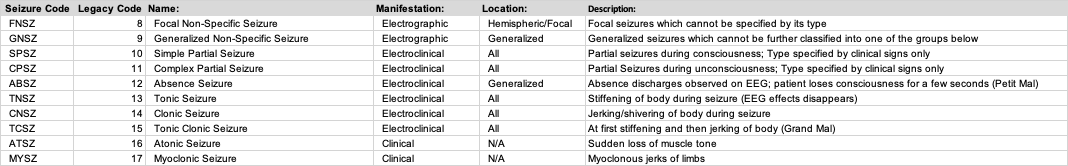

Note that two of the seizure types are clinically determined. We might want to avoid using these seizures when training models with EEG data.

EKG signal not always present, check `seizure.csv` for details. EKG units may differ from competition dataset. Need to compare...

Some competition spectrograms are missing considerable information. (For an example, see `/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/9661509.parquet`. More information is contained in [this notebook][4] and [this discussion][5]) This gives reason to include all seizures, regardless if 10 minutes of data exists, as long as there is a full 50-second EEG signal.

The dataset can be accessed [here][6]. An example of usage with EfficientNet can be found [here][7]. Please let me know your thoughts in this [discussion][8].

Huge thanks to Chris Deotte for his work on converting EEG signals to spectrograms!

[1]: https://isip.piconepress.com/projects/tuh_eeg/html/downloads.shtml
[2]: https://www.kaggle.com/datasets/psyryuvok/the-tuh-eeg-seizure-corpus-tusz-v152
[3]: https://isip.piconepress.com/publications/book_sections/2018/frontiers_neuroscience/tuh_eeg/
[4]: https://www.kaggle.com/code/seanbearden/missing-data-in-spectrograms
[5]: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/478233
[6]: https://www.kaggle.com/datasets/seanbearden/hms-hba-tuh-tusz-seizures
[7]: https://www.kaggle.com/code/seanbearden/effnetb0-2-pop-model-train-twice-lb-0-39
[8]: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/479244

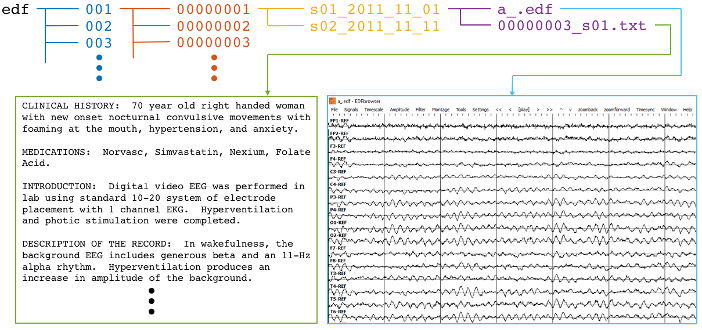

*Figure 1: Directory and file structure of the TUH-EEG database. Data is organized by patient (orange) and then by session (yellow). Each session contains one or more signal (edf) and physican report (txt) files. To accommodate filesystem management issues, patients are grouped into sets of about 100 (blue).*

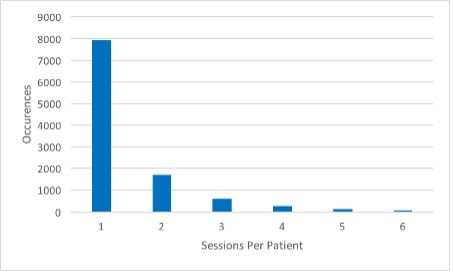
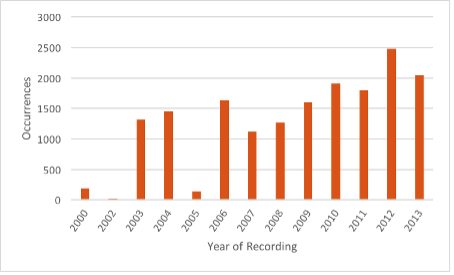
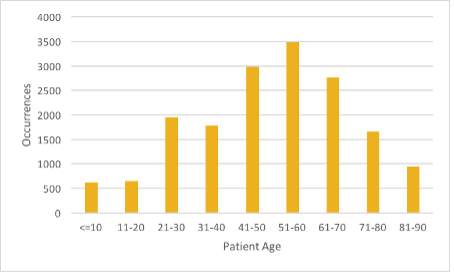
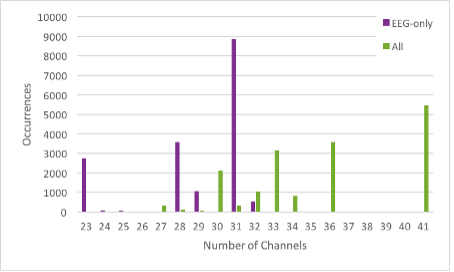

*Figure 2: Metrics describing the TUH-EEG corpus. [1st] histogram showing number of sessions per patient; [2nd] histogram showing number of sessions recorded per calendar year; [3rd] histogram of patient ages; [4th] histogram showing number of EEG-only channels (purple) and total channels (green).*

In [ ]:
! pip install pyedflib

In [ ]:
import os
import pyedflib
from pathlib import Path
import pandas as pd
import numpy as np

SAVE_DIRS = ['eeg_raw', 'eeg_10min_spec', 'eeg_50sec_spec']

for directory in SAVE_DIRS:
    if not os.path.exists(directory):
        Path(directory).mkdir(parents=True, exist_ok=True)
        
DATA_DIRS = ['train', 'dev']
REF_DIRS = {'01_tcp_ar': 'REF', '02_tcp_le': 'LE', '03_tcp_ar_a': 'REF'}
FREQUENCY = 200

SAVE_SEIZURES = True

SAVE_EEG_RAW = True
SAVE_SPEC_10MIN = True
SAVE_SPEC_50S = False
SAVE_SPEC_50S_NPY = False
SAVE_SPEC_10MIN_NPY = False


## Load Data

In [ ]:
# used for column arrangement 
spec_comp = pd.read_parquet('/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/9661509.parquet')

In [ ]:
import os

data_dict = {}
for directory in DATA_DIRS:
    for dirname, _, filenames in os.walk(f'/kaggle/input/the-tuh-eeg-seizure-corpus-tusz-v152/edf/{directory}'):
        for filename in filenames:
            if filename.split('.')[-1] == 'edf':
                dir_split = dirname.split('/')
                fn = filename.split('.')[0]

                with open(os.path.join(dirname, f'{fn}.tse'), 'r') as file:
                    for i, line in enumerate(file):
                        # events start on 3rd line.
                        if i >= 2:

                            info = line.strip().split()
                            data_dict[f'{fn}_{i-2}'] = {
                                'path': os.path.join(dirname, filename),
                                'reference_type': dir_split[6],
                                'group': dir_split[7],
                                'patient_id': dir_split[8],
                                'session': dir_split[9],
                                'start_time': float(info[0]),
                                'stop_time': float(info[1]),
                                'class_code': info[2],
#                                 'unkown_feature': float(info[3]),
                                'directory': directory
                            }

## EDA

In [ ]:
df = pd.DataFrame(data_dict).T
df['event_time'] = df['stop_time']-df['start_time']
df['EKG'] = False
df['processed'] = False
df.index.name = 'id'
df.reset_index(inplace=True)
df['missing_data'] = 0.0

print(f"There are {df['patient_id'].nunique()} patient ids.")
print(f"There are {df['session'].nunique()} recording sessions.")
print(f"There are {df[df['class_code']!='bckg']['session'].nunique()} sessions with seizure events.")
print(f"{(df['class_code']!='bckg').sum()} events have been labeled seizures.")
print(f"{(df['class_code']=='bckg').sum()} events have been labeled baseline/non-interesting events.")

df.head()

In [ ]:
df.class_code.value_counts().plot(kind='bar', title='All Event Labels');

In [ ]:
if SAVE_SEIZURES:
    # save seizures only
    df = df[df['class_code'] != 'bckg']
    df.class_code.value_counts().plot(kind='bar', title='All Non-Background Labels (Seizures)');
else:
    # save non-seizures
    df = df[df['class_code'] == 'bckg']

In [ ]:
df['event_time'].plot.hist(bins=100, title='Length of Recorded Seizures', xlabel='Seconds');

The dataset contains very long recordings of seizures, but most are under 10 minutes.

## Functions

In [ ]:
INCLUDED_CHANNELS = [
    'EEG FP1',
    'EEG F3',
    'EEG C3',
    'EEG P3',
    'EEG F7',
    'EEG T3',
    'EEG T5',
    'EEG O1',
    'EEG FZ',
    'EEG CZ',
    'EEG PZ',
    'EEG FP2',
    'EEG F4',
    'EEG C4',
    'EEG P4',
    'EEG F8',
    'EEG T4',
    'EEG T6',
    'EEG O2',
#     'EEG EKG1'
]

In [ ]:
def get_signals(edf, orderedChannels):
    samples = edf.getNSamples()[0]
    signals = np.zeros((len(orderedChannels), samples))
    for idx, ch in enumerate(orderedChannels):
        sig = edf.readSignal(ch)
        signals[idx, :] = sig
    return signals

In [ ]:
def get_channels(file_name, labels_object, channel_names):
    labels = list(labels_object)
    for i in range(len(labels)):
        labels[i] = labels[i].split("-")[0]

    ordered_channels = []
    for ch in channel_names:
        ordered_channels.append(labels.index(ch))
    return ordered_channels

In [ ]:
from scipy.signal import resample

def resample_signal(signals, to_freq, window_size):
    num = int(to_freq * window_size)
    resampled = resample(signals, num=num, axis=1)
    return resampled

In [ ]:
import librosa
import pywt
import matplotlib.pyplot as plt
USE_WAVELET = None

NAMES = ['LL','LP','RP','RR']

FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]

def spectrogram_from_eeg(eeg, display=False, offset=None):
    
    # LOAD MIDDLE 50 SECONDS OF EEG SERIES
#     eeg = pd.read_parquet(parquet_path)

    if offset is None:
        middle = (len(eeg)-10_000)//2
        eeg = eeg.iloc[middle:middle+10_000]
    else:
        eeg = eeg.iloc[offset:offset+10_000]
    
    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((128,256,4),dtype='float32')
    
    if display: plt.figure(figsize=(10,7))
    signals = []
    for k in range(4):
        COLS = FEATS[k]
        
        for kk in range(4):
        
            # COMPUTE PAIR DIFFERENCES
            x = eeg[COLS[kk]].values - eeg[COLS[kk+1]].values

            # FILL NANS
            m = np.nanmean(x)
            if np.isnan(x).mean() < 1: 
                x = np.nan_to_num(x,nan=m)
            else: x[:] = 0

            # DENOISE
            if USE_WAVELET:
                x = denoise(x, wavelet=USE_WAVELET)
            signals.append(x)

            # RAW SPECTROGRAM
            mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//256, 
                  n_fft=1024, n_mels=128, fmin=0, fmax=20, win_length=128)

            # LOG TRANSFORM
            width = (mel_spec.shape[1]//32)*32
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]

            # STANDARDIZE TO -1 TO 1
            mel_spec_db = (mel_spec_db+40)/40 
            img[:,:,k] += mel_spec_db
                
        # AVERAGE THE 4 MONTAGE DIFFERENCES
        img[:,:,k] /= 4.0
        
        if display:
            plt.subplot(2,2,k+1)
            plt.imshow(img[:,:,k],aspect='auto',origin='lower')
            # plt.title(f'EEG {eeg_id} - Spectrogram {NAMES[k]}')
            
    if display: 
        plt.show()
        plt.figure(figsize=(10,5))
        offset = 0
        for k in range(4):
            if k>0: offset -= signals[3-k].min()
            plt.plot(range(10_000),signals[k]+offset,label=NAMES[3-k])
            offset += signals[3-k].max()
        plt.legend()
        # plt.title(f'EEG {eeg_id} Signals')
        plt.show()
        print(); print('#'*25); print()
        
    return img


In [ ]:
from scipy.signal import spectrogram
from math import ceil
from functools import reduce

# ordered to align with competition spectrogram columns
NAMES_10MIN = ['LL','RL','LP','RP']

FEATS_10MIN = [['Fp1','F7','T3','T5','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F4','C4','P4','O2'],
]

def spectrogram_from_eeg_10min(eeg_df, sr, display=False, offset=None):
    eeg = eeg_df.copy()
    
    if display: plt.figure(figsize=(10,7))
    signals = []
    dfs = []
    for k in range(4):
        REGION = NAMES_10MIN[k]
        COLS = FEATS_10MIN[k]
        vals = []
        for kk in range(4):
        
            # COMPUTE PAIR DIFFERENCES
            x = eeg[COLS[kk]].values - eeg[COLS[kk+1]].values

            # FILL NANS
            m = np.nanmean(x)
            if np.isnan(x).mean() < 1: 
                x = np.nan_to_num(x,nan=m)
            else: x[:] = 0

            # DENOISE
            if USE_WAVELET:
                x = denoise(x, wavelet=USE_WAVELET)
            signals.append(x)

            frequencies, times, Sxx = spectrogram(x, fs=sr, window='hann', nperseg=400, noverlap=0, nfft=1024, detrend=False, scaling='density', mode='magnitude')
            freq_idx = [i for i, fr in enumerate(frequencies) if 0.5 < fr < 20]
            
            vals.append(Sxx[freq_idx, :].T)

        times_series = [int(t) for t in times]
        col_names = [f'{REGION}_{round(fr, 2)}' for fr in frequencies[freq_idx]]
        # Convert the list of arrays into a single multidimensional NumPy array
        stacked_arrays = np.stack(vals)
        # Compute the element-wise average
        elementwise_mean = np.mean(stacked_arrays, axis=0)

        df_spec = pd.DataFrame(times_series, columns=['time'])
        df_spec.loc[:, col_names] = elementwise_mean
        dfs.append(df_spec)
        if display:
            plt.subplot(2,2,k+1)
            sig = df_spec[col_names].fillna(0).T.values
            sig = np.clip(sig, np.exp(-4.0), np.exp(8.0))
            # Compute the logarithm of the array
            sig = np.log(sig)
            # Normalize the array
            sig -= np.mean(sig)
            sig /= (np.std(sig) + 1e-6)
            sig -= sig.min()
            sig /= sig.max() + 1e-4
            plt.imshow(sig,aspect='auto',origin='lower')
            
    if display: 
        plt.show()

    merged_df = reduce(lambda left, right: pd.merge(left, right, on='time', how='inner'), dfs)
    # not all rounded frequencies used to generate column names are in agreement with competition data.
    merged_df.columns = spec_comp.columns
    return merged_df


## Process Data
* Only want 20 channels, 19 if EKG if not available.
* Resampled at 200 Hz
* Save 50 second sample and spectrogram
* Save 10 minute spectrogram

In [ ]:
eeg_specs_50s = {}
eeg_specs_10min = {}

# loop over each file path
for edf_fn, dfs in df.groupby('path'):
    with pyedflib.EdfReader(edf_fn) as f:
        # assuming all sample frequencies the same...Not true for all signals, but appears to be true for signals of interest.
        sample_freq = f.getSampleFrequency(0)
        total_recording_len = f.readSignal(0).shape[0]
        total_recording_seconds = total_recording_len/sample_freq
        # use to verify all 20 signals in session
        signal_labels = f.getSignalLabels()
        
        # EKG not always present
        if f"EEG EKG1-{REF_DIRS[dfs.iloc[0]['reference_type']]}" in signal_labels:            
            orderedChannels = get_channels(edf_fn, signal_labels, INCLUDED_CHANNELS + ['EEG EKG1'])
        else:
            orderedChannels = get_channels(edf_fn, signal_labels, INCLUDED_CHANNELS)

        signals_ = get_signals(f, orderedChannels)
        
    # loop over all labeled seizures
    for idx, row in dfs.iterrows():  
        signals = np.copy(signals_)
        start = row['start_time']
        end = row['stop_time']
        VERIFY_SIGNAL_LABELS = [f"{ch}-{REF_DIRS[row['reference_type']]}" for ch in INCLUDED_CHANNELS]
        if len([l for l in VERIFY_SIGNAL_LABELS if l not in signal_labels]) > 0:
            continue
        # First try to center on mean time of seizure
        seizure_mean_time = start + (end - start)/2

        # need to make sure the 10 min and 50 sec are aligned.
        if total_recording_seconds >= 50:
            # might need to verify that shifting 50 second signal does not violate boundaries
            print(row['id'])
            
            spec_cutoff = 300
            sig_cutoff = 25
            if seizure_mean_time < sig_cutoff:
                # move middle to sig_cutoff, and check that seizure has not ended.
                if end > sig_cutoff:
                    df.loc[idx, 'processed'] = True
                    eeg_start_idx = 0
                    eeg_stop_idx = round(2 * sig_cutoff * sample_freq)
                    spec_start_idx = -(spec_cutoff - sig_cutoff)
                    spec_stop_idx = round((sig_cutoff + spec_cutoff)* sample_freq)
                else:
                    continue
            elif seizure_mean_time + sig_cutoff > total_recording_seconds:
                # move middle to total_recording_seconds - sig_cutoff, and check that seizure has started.
                if start > total_recording_seconds-sig_cutoff:
                    df.loc[idx, 'processed'] = True
                    eeg_stop_idx = total_recording_len
                    eeg_start_idx = eeg_stop_idx - round(2 * sig_cutoff * sample_freq)
                    spec_stop_idx = total_recording_len + (spec_cutoff - sig_cutoff)
                    spec_start_idx = spec_stop_idx - round((spec_cutoff + sig_cutoff) * sample_freq)
                else:
                    continue
            else:
                df.loc[idx, 'processed'] = True
                eeg_start_idx = round((seizure_mean_time - sig_cutoff) * sample_freq)
                eeg_stop_idx = round((seizure_mean_time + sig_cutoff) * sample_freq)
                spec_start_idx = round((seizure_mean_time - spec_cutoff) * sample_freq)
                spec_stop_idx = round((seizure_mean_time + spec_cutoff) * sample_freq)
            
            while (spec_stop_idx-spec_start_idx)/sample_freq < 600:
                spec_stop_idx += 1
            while (spec_stop_idx-spec_start_idx)/sample_freq > 600:
                spec_stop_idx -= 1
            while (eeg_stop_idx-eeg_start_idx)/sample_freq < 50:
                eeg_stop_idx += 1
            while (eeg_stop_idx-eeg_start_idx)/sample_freq > 50:
                eeg_stop_idx -= 1

                # create 10 min
            spec_start_idx_missing = None
            spec_stop_idx_missing = None

            if spec_start_idx < 0:
                spec_start_idx_missing = -spec_start_idx
                spec_start_idx = 0
            if spec_stop_idx > signals.shape[1]:
                spec_stop_idx_missing = spec_stop_idx - signals.shape[1]
                spec_stop_idx = signals.shape[1]

            desired_shape = (signals.shape[0], round(2 * spec_cutoff * sample_freq))
            result = np.full(desired_shape, 0.0)
            
            spec_array = np.array(signals[:, spec_start_idx:spec_stop_idx])

            df.loc[idx, 'missing_data'] = 1 - spec_array.shape[1]/desired_shape[1]

            if spec_start_idx_missing is not None:
                result[:, spec_start_idx_missing:spec_start_idx_missing + spec_array.shape[1]] = spec_array
            elif (spec_start_idx_missing is None) & (spec_stop_idx_missing is not None):
                result[:, :spec_array.shape[1]] = spec_array
            else:
                result = spec_array
            
            # resample so frequency is 200 Hz
            eeg_array = np.array(signals[:, eeg_start_idx:eeg_stop_idx])
            eeg_raw_arr = resample_signal(
                eeg_array,
                to_freq=FREQUENCY,
                window_size=int(eeg_array.shape[1] / sample_freq),
            )
            assert eeg_raw_arr.shape[1] == 10000      
            
            spec_eeg_arr = resample_signal(
                result,
                to_freq=FREQUENCY,
                window_size=int(result.shape[1] / sample_freq),
            )
            assert spec_eeg_arr.shape[1] == FREQUENCY * 600
            
            col_names = [col.split()[1] for col in INCLUDED_CHANNELS]
            col_names = [s[0] + s[1:].lower() for s in col_names]
            if f"EEG EKG1-{REF_DIRS[row['reference_type']]}" in signal_labels:
                df.loc[idx, 'EKG'] = True
                spec_eeg_df = pd.DataFrame(spec_eeg_arr, index=col_names + ['EKG']).T
                eeg_df = pd.DataFrame(eeg_raw_arr, index=col_names + ['EKG']).T
            else:
                spec_eeg_df = pd.DataFrame(spec_eeg_arr, index=col_names).T
                spec_eeg_df['EKG'] = np.nan
                eeg_df = pd.DataFrame(eeg_raw_arr, index=col_names).T
                eeg_df['EKG'] = np.nan

            # Save data and generate spectrograms if needed
            if SAVE_SPEC_10MIN | SAVE_SPEC_10MIN_NPY:
                spec_1 = spectrogram_from_eeg_10min(spec_eeg_df, FREQUENCY, display=False)
                if SAVE_SPEC_10MIN:
                    spec_1.to_parquet(os.path.join(SAVE_DIRS[1], f"{row['id']}.parquet"))
                if SAVE_SPEC_10MIN_NPY:
                    eeg_specs_10min[row['id']] = spec_1.iloc[:, 1:].values
                
            if SAVE_EEG_RAW:    
                eeg_df.to_parquet(os.path.join(SAVE_DIRS[0], f"{row['id']}.parquet"))
                
            if SAVE_SPEC_50S | SAVE_SPEC_50S_NPY:
                spec_50s = spectrogram_from_eeg(eeg_df)
                if SAVE_SPEC_50S:
                    np.save(os.path.join(save_dir[2], row['id']),spec_50s)
                if SAVE_SPEC_50S_NPY:
                    eeg_specs_50s[row['id']] = spec_50s
        else:
            # signal not 50 seconds
            continue
            
if SAVE_SPEC_10MIN_NPY:
    np.save('eeg_specs_10min', eeg_specs_10min)
    
if SAVE_SPEC_50S_NPY:
    np.save('eeg_specs_50s', eeg_specs_50s)

In [ ]:
# ! cp /kaggle/input/hms-hba-tuh-tusz-seizures/eeg_10min_spec/kaggle/working/eeg_10min_spec/* /kaggle/working/eeg_10min_spec/
# ! cp /kaggle/input/hms-hba-tuh-tusz-seizures/eeg_raw/kaggle/working/eeg_raw/* /kaggle/working/eeg_raw/
# ! cp /kaggle/input/hms-hba-tuh-tusz-seizures/seizures.csv /kaggle/working/

In [ ]:
! tar -cvf /kaggle/working/eeg_raw.tar -C /kaggle/working/eeg_raw .
!cd /kaggle/working
!rm -rf eeg_raw

In [ ]:
! tar -cvf /kaggle/working/eeg_10min_spec.tar -C /kaggle/working/eeg_10min_spec . 

!cd /kaggle/working
!rm -rf eeg_10min_spec

In [ ]:
if SAVE_SEIZURES:
    df.to_csv('seizures.csv', index=False)
else:
    df.to_csv('background.csv', index=False)

# Spectrograms

In [ ]:
spec_1 = spectrogram_from_eeg_10min(spec_eeg_df, FREQUENCY, display=True)

In [ ]:
import tensorflow as tf
ddff = spec_comp.fillna(0)
sig = ddff.iloc[:300, 1:101].T.values
sig
# Log spectrogram 
sig = tf.clip_by_value(sig, tf.math.exp(-4.0), tf.math.exp(8.0)) # avoid 0 in log
sig = tf.math.log(sig)

# Normalize spectrogram
sig -= tf.math.reduce_mean(sig)
sig /= tf.math.reduce_std(sig) + 1e-6

# Plot the spectrogram
times = ddff.iloc[:300]['time']
frequencies = [float(c.split('_')[-1]) for c in ddff.columns if c[:2] == 'LL']
img = sig.numpy() #ddff.iloc[:300, 1:101].T
img -= img.min()
img /= img.max() + 1e-4
plt.figure(figsize=(10, 4))
plt.pcolormesh(times, frequencies, img, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Linear-frequency power spectrogram')
# plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()